
Automatic piping vmtkmarchingcubes
Parsing options vmtkmarchingcubes
    ImageInputFileName = manual-work/segmentation/sub-5/artery-label.nii
    Level = 0.1
Explicit piping vmtkmarchingcubes
Input vmtkmarchingcubes members:
    Id = 0
    Disabled = 0
    Image = None
    ImageInputFileName = manual-work/segmentation/sub-5/artery-label.nii
    ArrayName = 
    Level = 0.1
    Connectivity = 0
    SurfaceOutputFileName = 
Spacing 1.562500 1.560000 1.562500
Origin -309.333374 -128.863434 -246.379395
Dimensions 384 160 384
Executing vmtkmarchingcubes ...
Done executing vmtkmarchingcubes.
Output vmtkmarchingcubes members:
    Id = 0
    Surface = vtkPolyData

Automatic piping vmtksurfacesmoothing
    Surface = vmtkmarchingcubes-0.Surface
Parsing options vmtksurfacesmoothing
    NumberOfIterations = 30
    PassBand = 0.15
    SurfaceOutputFileName = vmtk-output/sub-5/sub-5_artery-label.vtp
Explicit piping vmtksurfacesmoothing
Input vmtksurfacesmoothing members:
    Id = 0
    Disabled = 0

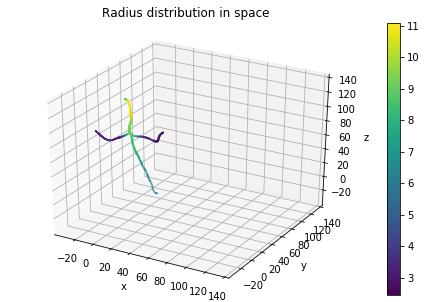

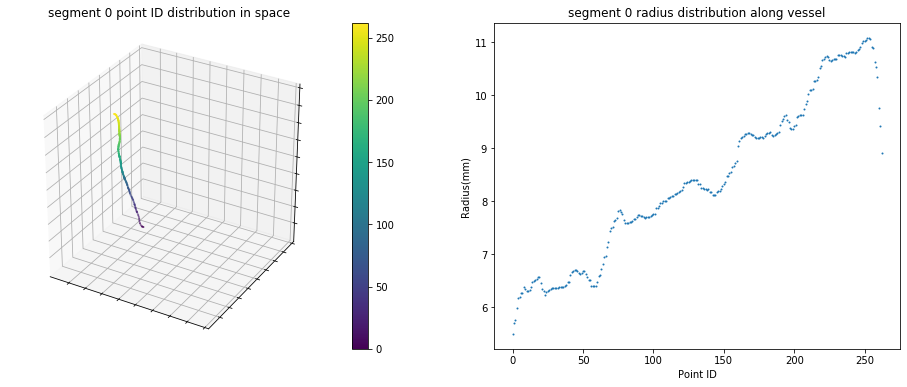

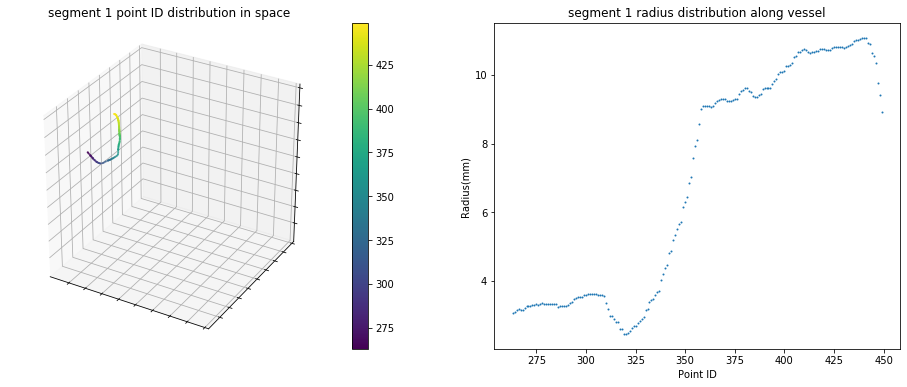

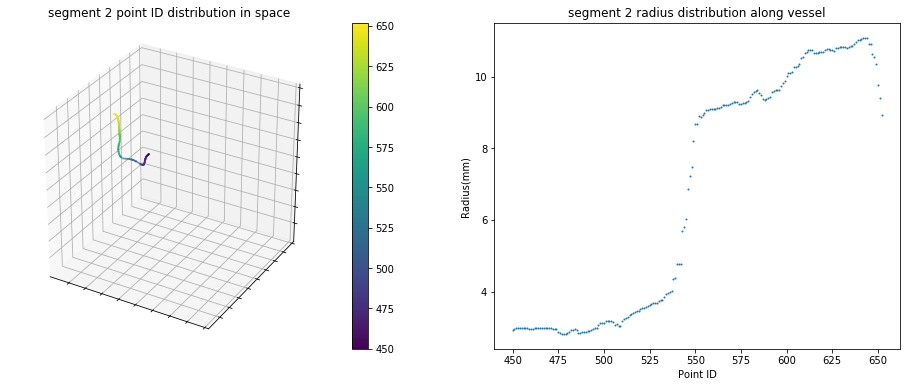

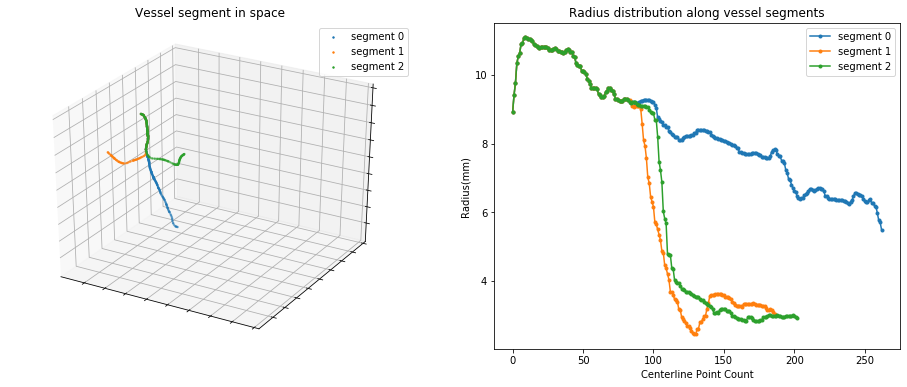

In [2]:
# -----------------------------------------------------------------
# This code is to implement vmtk to analyze the vessel structure. 
#   + vmtk analysis
#       - surface extraction: nii to vtp, with surface smoothing
#       - centerline extraction: specify source and target by 
#                                   manually selecting
#       - centerline reading: reading result from centerline output
#   + output
#       - plotting: look at centerline point ID distribution and 
#                       radius distribution
#       - save data: output to csv file
#
#                   Tianyi Zhou, Yue Lyu
#                         10/29/2019
# -----------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from vmtk import pypes
from vmtk import vmtkscripts

num = 5
side = "left"


niifolder = "manual-work/segmentation/sub-{}/".format(num)
vmtkfolder = "vmtk-output/sub-{}/".format(num)

# --------vmtk: surface extraction--------------
inSurfaceXtrct = niifolder + "artery-label.nii"
passband = 0.15
outSurfaceXtrct = vmtkfolder + "sub-{}_".format(num) + "artery-label.vtp"
cmdSurfaceXtrct = "vmtkmarchingcubes -ifile {} -l 0.1 --pipe vmtksurfacesmoothing -passband {} -iterations 30 -ofile {} --pipe vmtksurfaceviewer".format(inSurfaceXtrct,passband,outSurfaceXtrct)  # input filtered artery
pypes.PypeRun(cmdSurfaceXtrct)

# vmtk: vessel clipping
#inClipper = outSurfaceXtrct
#outClipper = vmtkfolder + "sub-{}_".format(num) + side + "-artery-openended.vtp"

#if not os.path.exists(outClipper):
#	cmdClipper = "vmtksurfaceclipper -ifile {} -ofile {}".format(inClipper,outClipper)
#	pypes.PypeRun(cmdClipper)

# vmtk: centerline extraction
# Uncomment the two lines below and comment current working two to compute centerline using manual selection
#inCenterline = outClipper
inCenterline = outSurfaceXtrct
outCenterline = vmtkfolder + "sub-{}_".format(num) + "artery-centerline.vtp"
#cmdCenterline = "vmtksurfacereader -ifile {} --pipe vmtkcenterlines -seedselector openprofiles --pipe vmtkrenderer --pipe vmtksurfaceviewer -opacity 0.25 --pipe vmtksurfaceviewer -i @vmtkcenterlines.o -array DistanceToCenterlines -ofile {}".format(inCenterline,outCenterline)
cmdCenterline = "vmtksurfacereader -ifile {} --pipe vmtkcenterlines --pipe vmtkrenderer --pipe vmtksurfaceviewer -opacity 0.25 --pipe vmtksurfaceviewer -i @vmtkcenterlines.o -array DistanceToCenterlines -ofile {}".format(inCenterline,outCenterline)
pypes.PypeRun(cmdCenterline)


# centerline reading
centerlineReader = vmtkscripts.vmtkSurfaceReader()
centerlineReader.InputFileName = outCenterline
centerlineReader.Execute()
clNumpyAdaptor = vmtkscripts.vmtkCenterlinesToNumpy()
clNumpyAdaptor.Centerlines = centerlineReader.Surface
clNumpyAdaptor.Execute()
numpyCenterlines = clNumpyAdaptor.ArrayDict

points = numpyCenterlines['Points']
pointsIds = np.arange(len(points))
radius = numpyCenterlines['PointData']['MaximumInscribedSphereRadius']
segPointIds = numpyCenterlines['CellData']['CellPointIds']
numSegments = len(segPointIds)



# -----------------------------------------------------------------
# Plotting


fig1 = plt.figure(figsize=(8, 5))
ax1 = fig1.add_subplot(111, projection='3d')

axis_min = min(np.reshape(points,-1)) - 10
axis_max = max(np.reshape(points,-1)) + 10

ax1.set_xlim3d(axis_min,axis_max)
ax1.set_ylim3d(axis_min,axis_max)
ax1.set_zlim3d(axis_min,axis_max)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.title.set_text('Radius distribution in space')
im1 = ax1.scatter(points[:,0],points[:,1],points[:,2],c=radius,s=1)
fig1.colorbar(im1)

fig1_path = vmtkfolder + "sub-{}_".format(num) + "artery-radius_in_space.png"
plt.savefig(fig1_path)


for segId in range(numSegments):
    segment = segPointIds[segId]
    
    fig2 = plt.figure(figsize=(16, 6))
    
    ax1 = fig2.add_subplot(121, projection='3d')
    ax1.title.set_text('segment {} point ID distribution in space'.format(segId))
    ax1.set_xlim3d(axis_min,axis_max)
    ax1.set_ylim3d(axis_min,axis_max)
    ax1.set_zlim3d(axis_min,axis_max)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    im1 = ax1.scatter(points[segment,0],points[segment,1],points[segment,2],c=segment,s=1)
    fig2.colorbar(im1)

    ax2 = fig2.add_subplot(122)
    ax2.title.set_text('segment {} radius distribution along vessel'.format(segId))
    ax2.set_xlabel('Point ID')
    ax2.set_ylabel('Radius(mm)')    
    ax2.scatter(segment,radius[segment],s=1)
    
    fig2_path = vmtkfolder + "sub-{}_".format(num) + "artery_segment-{}.png".format(segId)
    plt.savefig(fig2_path)


fig3 = plt.figure(figsize=(16,6))

ax1 = fig3.add_subplot(121, projection='3d')
ax2 = fig3.add_subplot(122)

for segId in range(numSegments):
    segment = segPointIds[segId]
    #ax.plot(range(len(segment)),radius[segment],marker='.',label='segment {}'.format(segId))
    ax1.scatter(points[segment,0],points[segment,1],points[segment,2],s=2,label='segment {}'.format(segId))
    ax2.plot(range(len(segment)),radius[segment],marker='.',label='segment {}'.format(segId))
    
ax1.set_xlim3d(axis_min,axis_max)
ax1.set_ylim3d(axis_min,axis_max)
ax1.set_zlim3d(axis_min,axis_max)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])
ax1.title.set_text('Vessel segment in space')
ax1.legend()

ax2.title.set_text('Radius distribution along vessel segments')
ax2.set_xlabel('Centerline Point Count')
ax2.set_ylabel('Radius(mm)')    
ax2.legend()

fig3_path = vmtkfolder + "sub-{}_".format(num) + "artery-radius.png"
plt.savefig(fig3_path)

#plt.show()

# Save data to csv
frames = []
for segId in range(numSegments):
    segment = segPointIds[segId]
    segData = pd.DataFrame({'pointId':segment,'segId':segId*np.ones(len(segment), dtype=int),'x':points[segment,0],'y':points[segment,1],'z':points[segment,2],'radius':radius[segment]})
    frames.append(segData)    
CenterlineData = pd.concat(frames)
print(CenterlineData)
outDataframe = vmtkfolder + "sub-{}_".format(num) + "artery-clData.csv"
CenterlineData.to_csv(outDataframe,index=False)



